### Validation by aspect ratio

Instead of center cropping, sort validation images by aspect ratio. Crop batches of these images based on the closest aspect ratio

In [1]:
import argparse, os, shutil, time, warnings
from datetime import datetime
from pathlib import Path
import numpy as np
import sys

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
from fp16util import network_to_half, set_grad, copy_in_params

In [2]:
from torch.utils.data.sampler import Sampler
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import os.path
import urllib.request
import pandas as pd

In [3]:
cudnn.benchmark = True
data = '/home/paperspace/data/imagenet'
workers = 7
valdir = os.path.join(data, 'validation')
batch_size = 128

## Create Image to Aspect ratio mapping

In [4]:
# Step 1: sort images by aspect ratio
def sort_ar(valdir):
    idx2ar_file = data+'/sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Creating AR indexes. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir)
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    return sorted_idxar

# Step 2: chunk images by batch size. This way we can crop each image to the batch aspect ratio mean 
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

# Step 3: map image index to batch aspect ratio mean so our transform function knows where to crop
def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    ar_means = []
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        ar_means.append(mean)
        for idx in idxs:
            idx2ar[idx] = mean
    return idx2ar, ar_means

In [5]:
idx_ar_sorted = sort_ar(valdir)

#### OR just download it

In [6]:
idx2ar_path = data+'/sorted_idxar.p'
url = 'https://s3-us-west-2.amazonaws.com/ashaw-fastai-imagenet/sorted_idxar.p'
if not os.path.exists(idx2ar_path): urllib.request.urlretrieve(url, idx2ar_path)
idx_ar_sorted = sort_ar(valdir)

## Dataset Preparation

In [7]:
class ValDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, idx_transform=None):
        super().__init__(root, transform, target_transform)
        self.idx_transform = idx_transform
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.idx_transform(sample, index)
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

# Essentially a sequential sampler
class ARSampler(Sampler):
    def __init__(self, indices): self.indices = indices
    def __len__(self): return len(self.indices)
    def __iter__(self): return iter(self.indices)
    


In [8]:
class ArCropTfm(object):
    def __init__(self, idx2ar, target_size):
        self.idx2ar, self.target_size = idx2ar, target_size
    def __call__(self, img, idx):
        target_ar = self.idx2ar[idx]
        if target_ar < 1: 
            w = int(self.target_size/target_ar)
            size = (w//8*8, self.target_size)
        else: 
            h = int(self.target_size*target_ar)
            size = (self.target_size, h//8*8)
        return torchvision.transforms.functional.center_crop(img, size)
    
# For data augmentation
class RandomArCropTfm(object):
    def __init__(self, idx2ar, target_size):
        self.idx2ar, self.target_size = idx2ar, target_size
        self.rc = transforms.RandomCrop(0)
    def __call__(self, img, idx):
        target_ar = self.idx2ar[idx]
        if target_ar < 1: 
            w = int(self.target_size/target_ar)
            size = (w//8*8, self.target_size)
        else: 
            h = int(self.target_size*target_ar)
            size = (self.target_size, h//8*8)
        self.rc.size = size
        img = self.rc(img)
        return img

### Custom Data loaders

In [9]:
def tfm_wrapper_idx(fn):
    return lambda x,idx: (fn(x),idx)
def tfm_wrapper(fn):
    return lambda x,idx: fn(x)

In [10]:
class ValDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            for tfm in self.transform:
                if isinstance(tfm, ArCropTfm) or isinstance(tfm, RandomArCropTfm): sample = tfm(sample, index)
                else: sample = tfm(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


### Global dataset settings

In [11]:
val_bs = 128
target_size = 288

idx_sorted, _ = zip(*idx_ar_sorted)
idx2ar, ar_means = map_idx2ar(idx_ar_sorted, val_bs)
val_sampler_ar = ARSampler(idx_sorted)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tensor_tfm = [transforms.ToTensor(), normalize]



        

### Test validation with aspect ratio transforms

In [44]:
target_size = 128

In [45]:
# Aspect Ratio
val_ar_tfms = [transforms.Resize(int(target_size*1.14)), ArCropTfm(idx2ar, target_size)]
val_dataset_ar = ValDataset(valdir, val_ar_tfms)

# No transforms
orig_dataset = datasets.ImageFolder(valdir, transforms.Resize(target_size))

val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)]
val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))

min_scale = 0.5
trn_tfms = [
        transforms.RandomResizedCrop(target_size, scale=(min_scale, 1.0)),
        transforms.RandomHorizontalFlip(),
    ]
aug_dataset = datasets.ImageFolder(valdir, transforms.Compose(trn_tfms))


In [48]:
def show_validation_image(index):
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(24, 24))
    f.tight_layout()
    ax1[0].imshow(orig_dataset[index][0])
    ax1[0].set_title('Original Image', fontsize=20)
    ax1[1].imshow(val_dataset_ar[index][0])
    ax1[1].set_title('Aspect Ratio Crop', fontsize=20)
    ax2[0].imshow(val_dataset[index][0])
    ax2[0].set_title('Dawn Validation', fontsize=20)
    ax2[1].imshow(aug_dataset[index][0])
    ax2[1].set_title('TTA 1', fontsize=20)
    ax3[0].imshow(aug_dataset[index][0])
    ax3[0].set_title('TTA 2', fontsize=20)
    ax3[1].imshow(aug_dataset[index][0])
    ax3[1].set_title('TTA 3', fontsize=20)
#     plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

### Tall Images

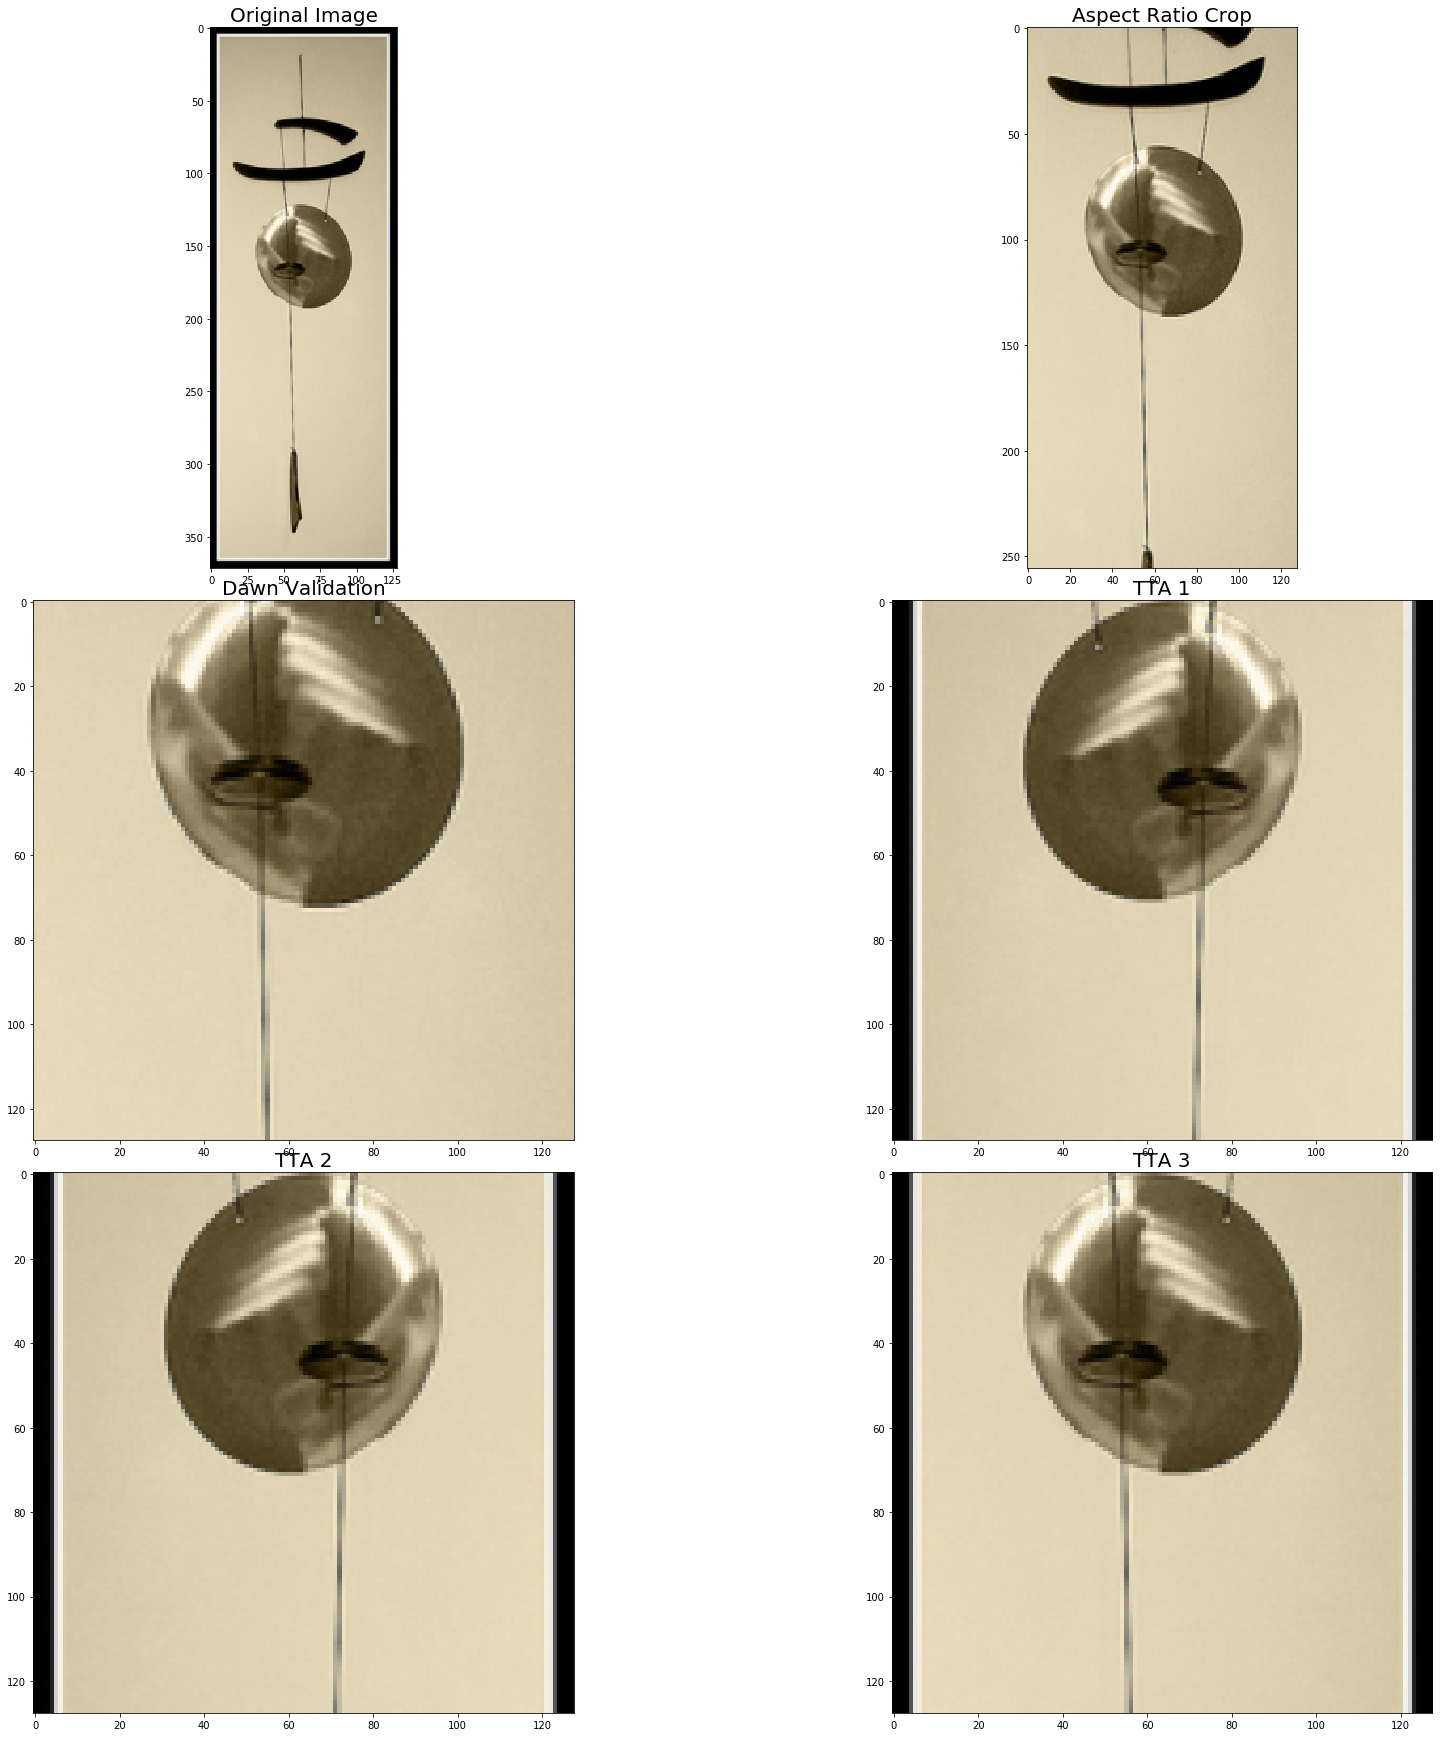

In [58]:
show_validation_image(idx_sorted[8])

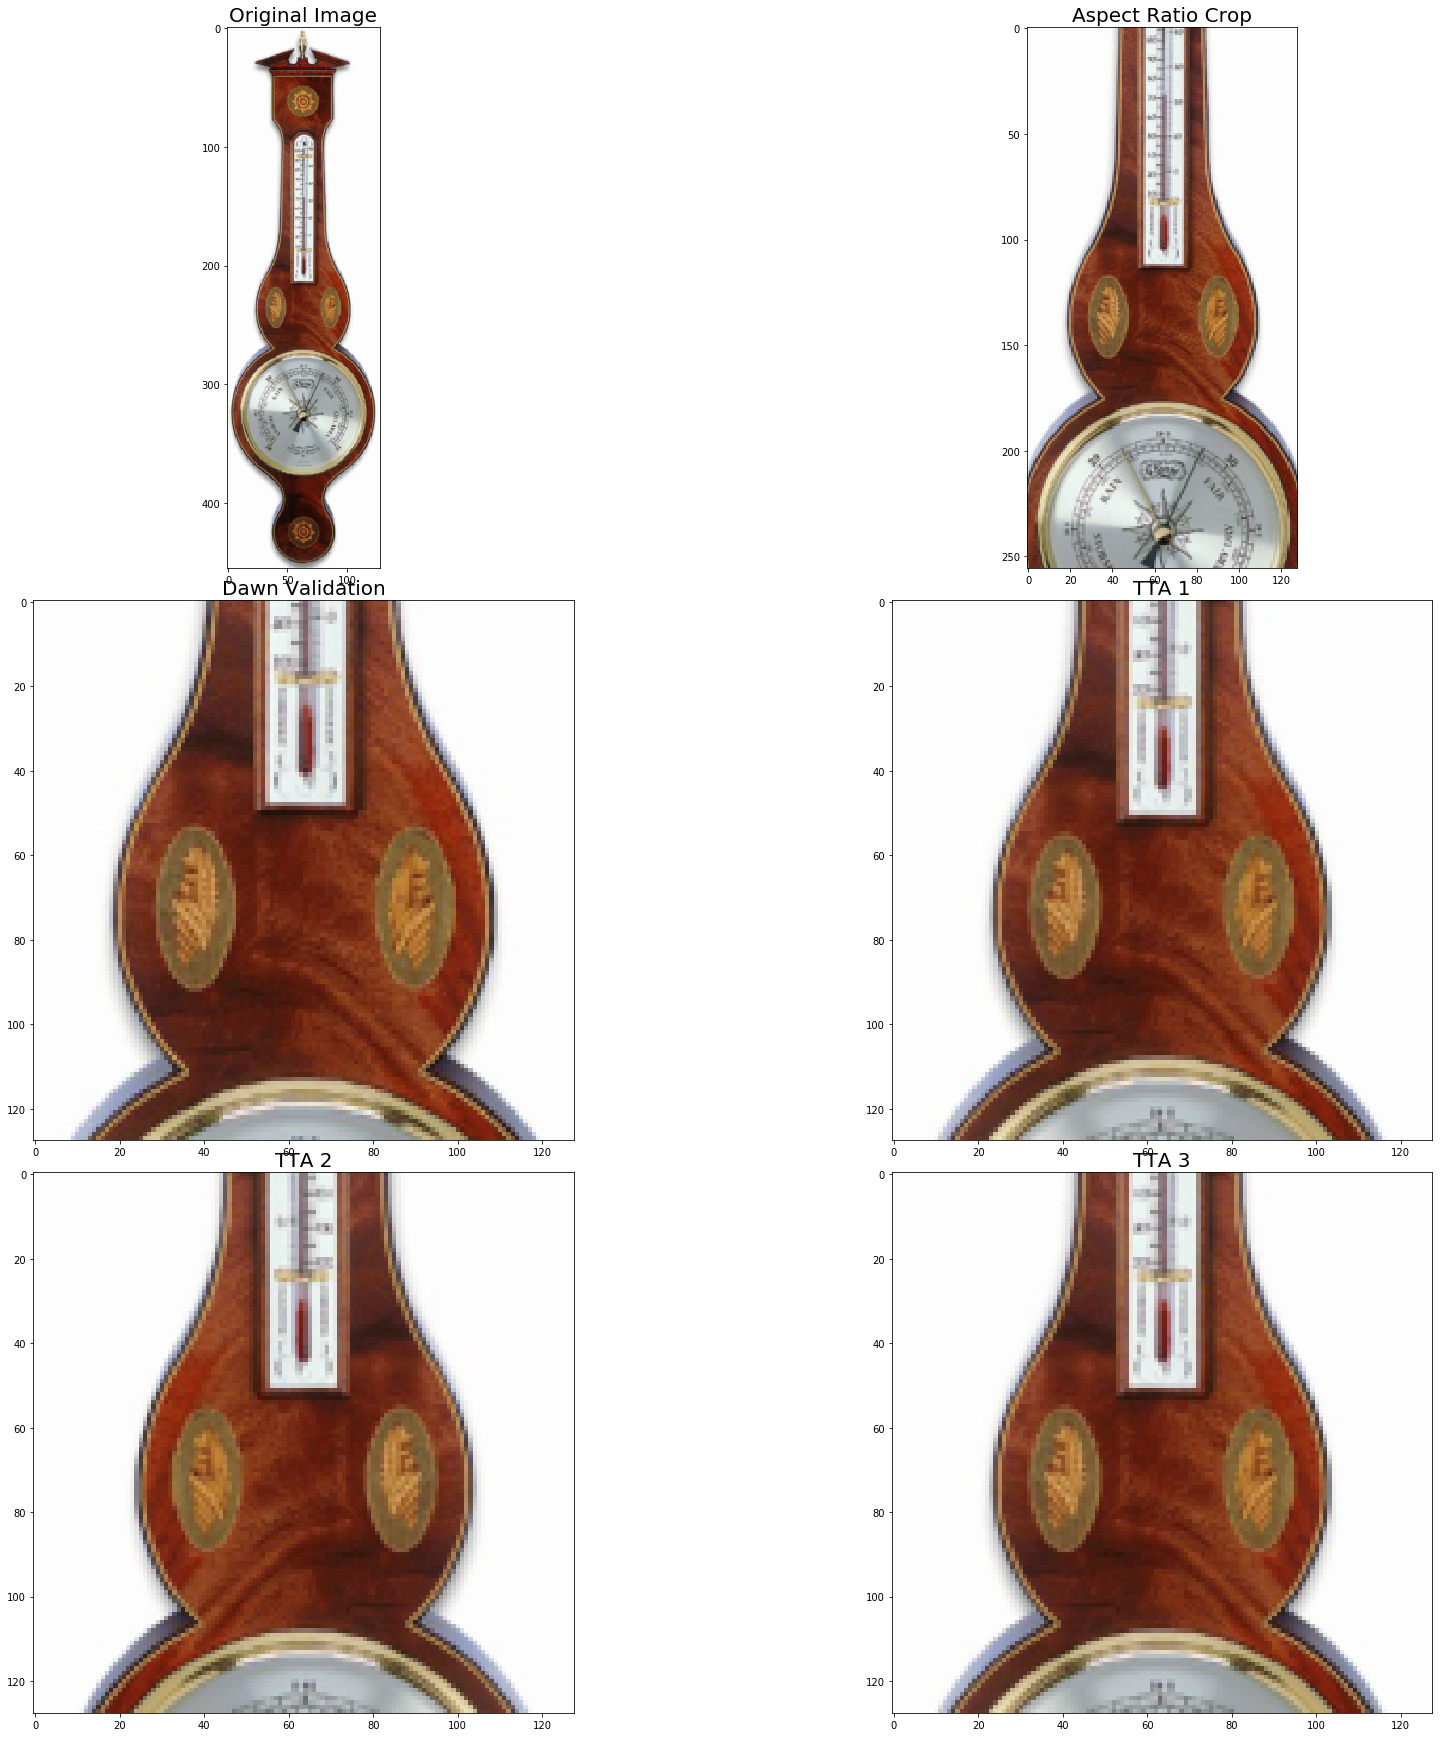

In [49]:
show_validation_image(idx_sorted[3])

### Wide images

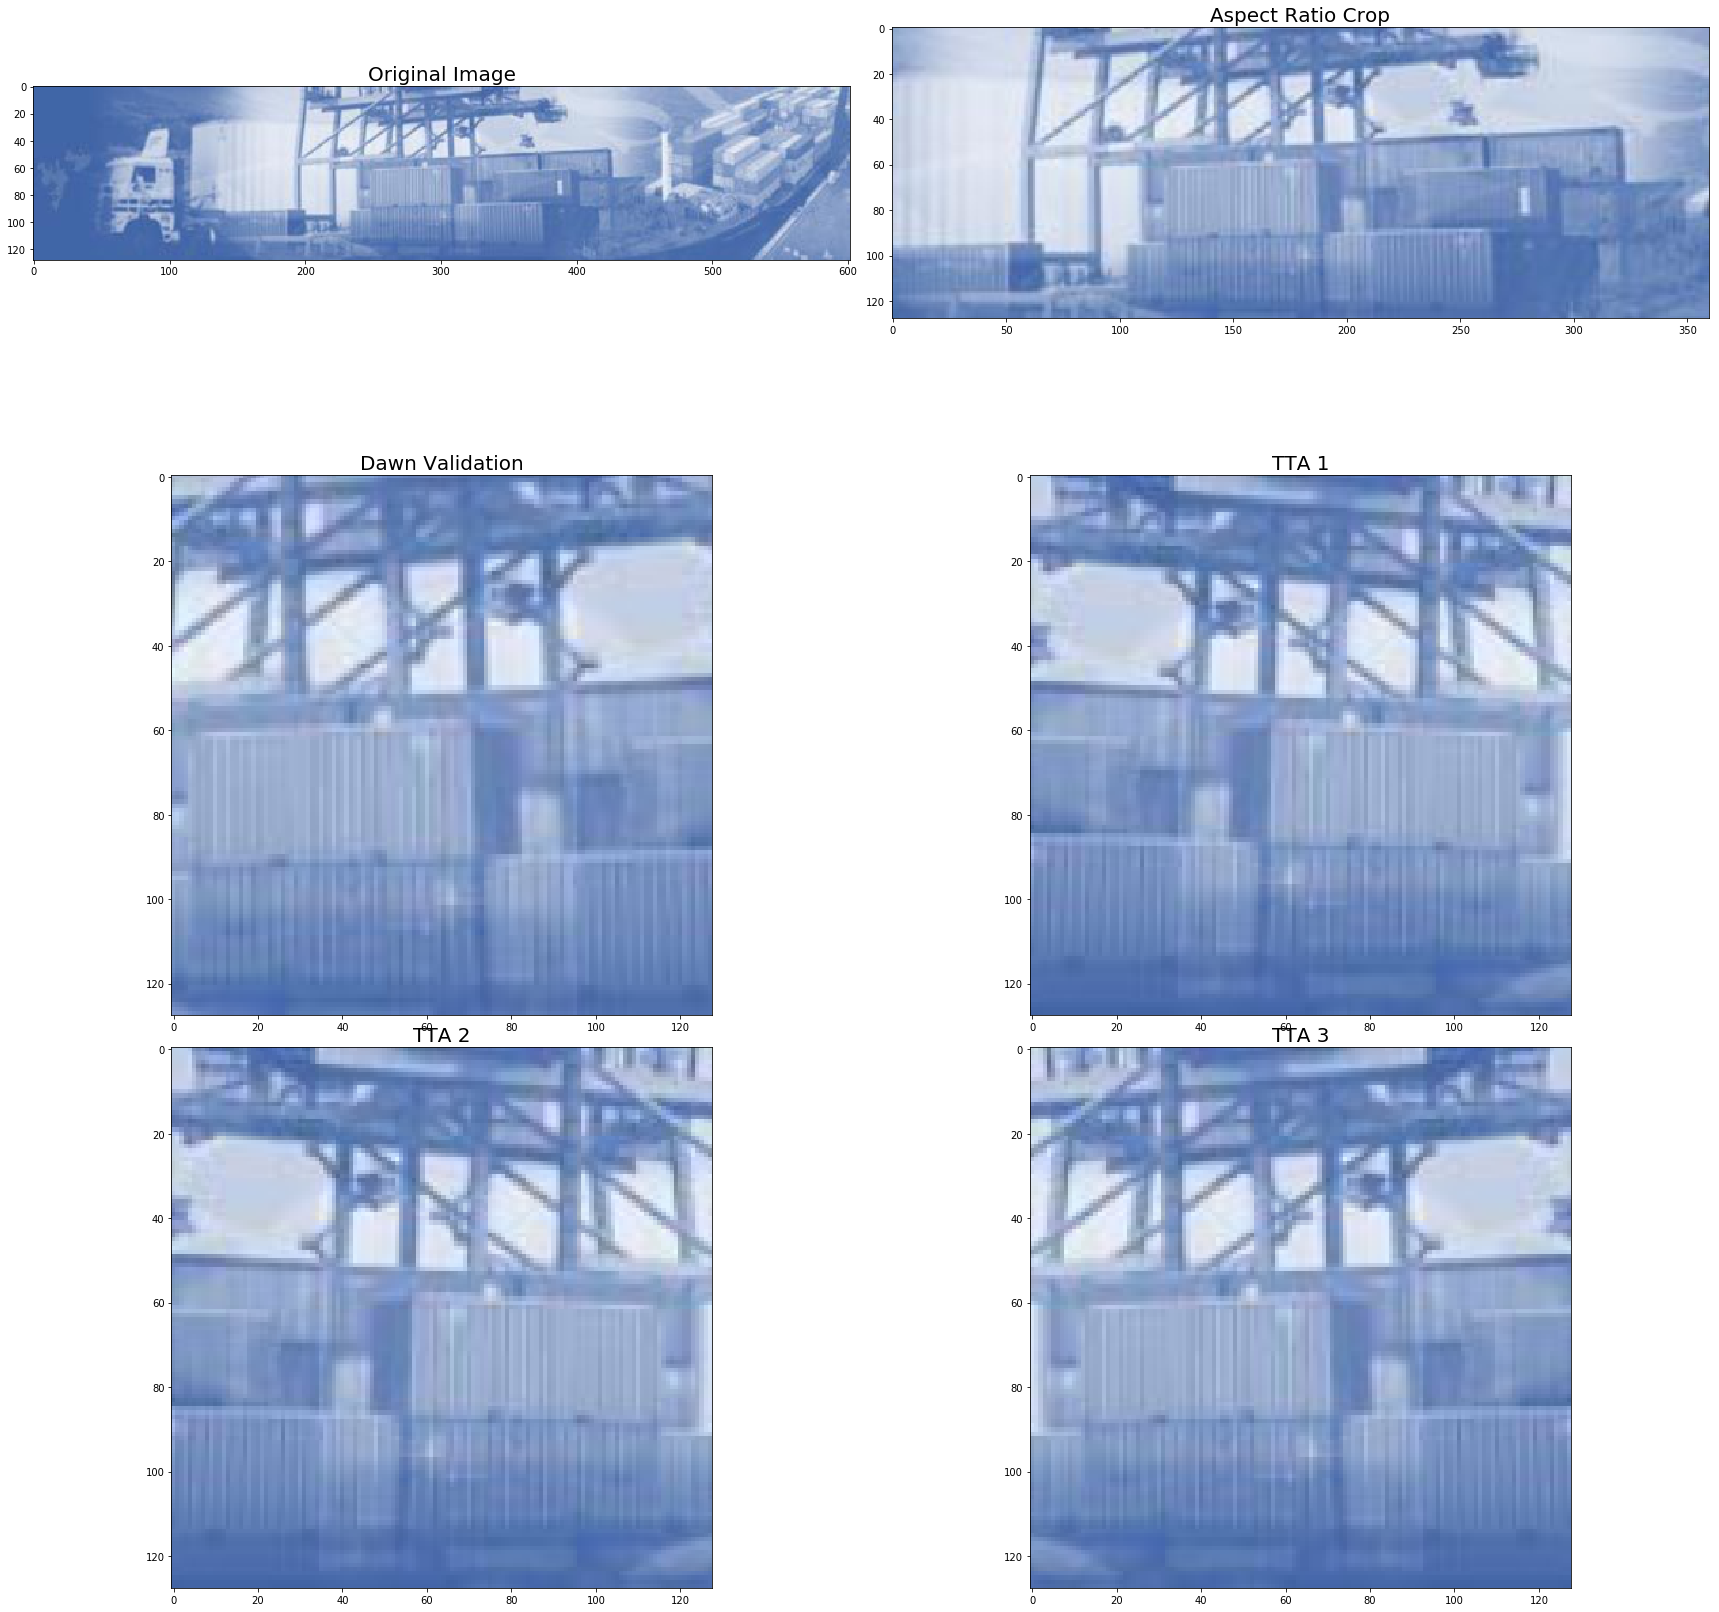

In [50]:
show_validation_image(idx_sorted[-3])

### Already square images - Aspect ratio of 1

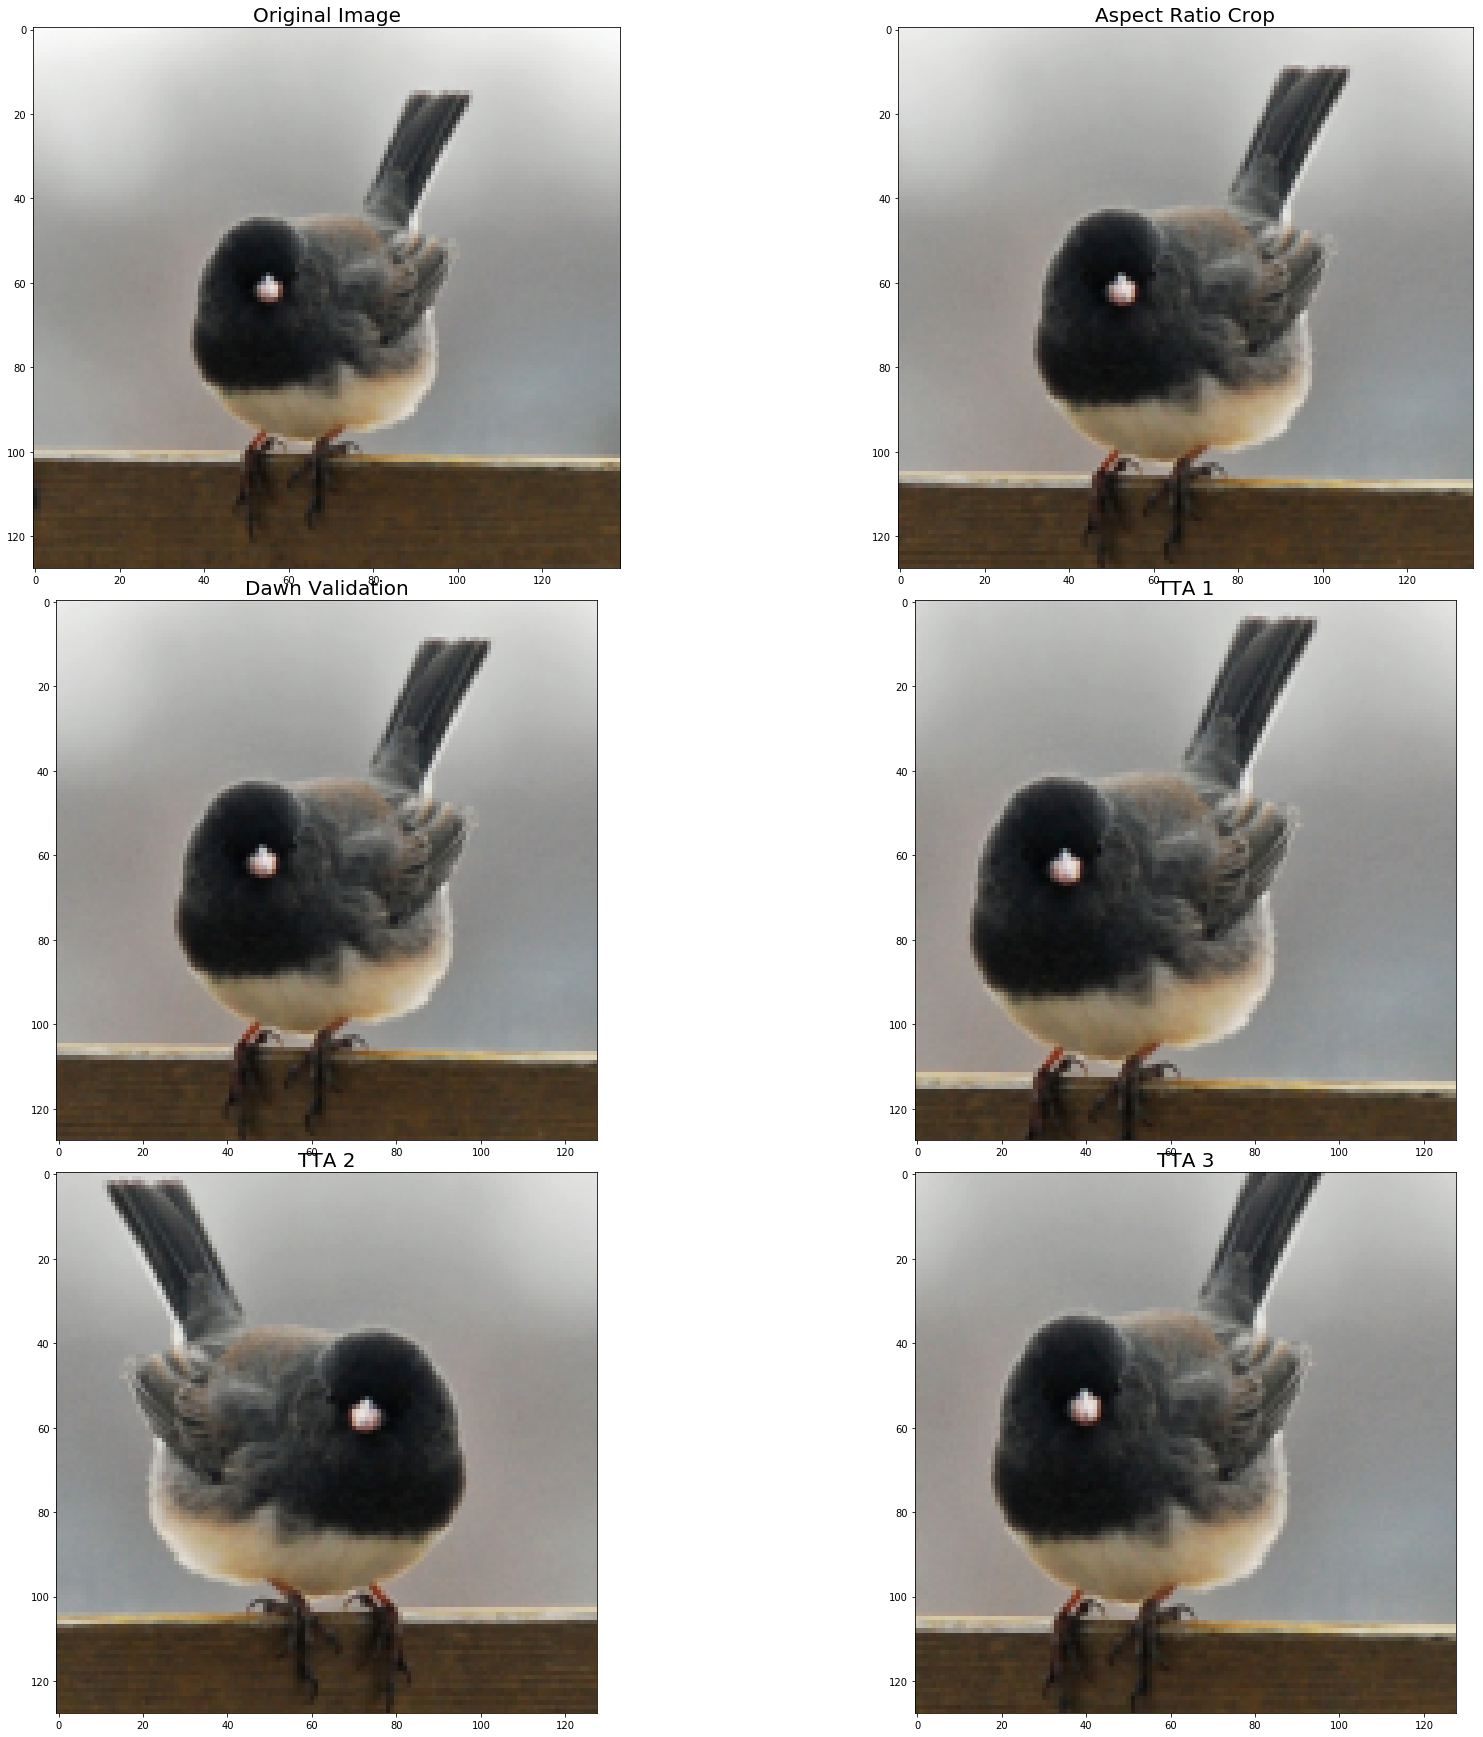

In [59]:
show_validation_image(idx_sorted[len(idx_sorted)//3])